In [1]:
import pandas as pd
import numpy as np
import re
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
import string
import joblib
import function_library as fl
import math
from collections import Counter
from itertools import chain
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from spacy.lang.pt.stop_words import STOP_WORDS
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report

In [2]:
pd.set_option('display.max_colwidth', 1000)

In [3]:
all_cus_go = pd.read_csv('F:\\mailae_g\\ALL_PL_2022.csv', sep=';')

In [4]:
email_encoder = LabelEncoder()

all_cus_go['Requester Email'] = email_encoder.fit_transform(all_cus_go['Requester Email'])

In [5]:
all_cus_go.head()

,Ticket Id,Subject,Description,Source,Requester Email,Created Time,Agent interactions,Customer interactions,Tags
0,111345,[DE] [PYTANIE] B07R42W8J9,Klient ma pytanie do produktu B07R42W8J9: &quot;Jakie połączenie ma dachówka wentylacyjna?&quot; Link do zapytania: www.amazon.de/ask/question/Tx21NZNJ8PMI5JH?_encoding=UTF8&amp;authToken=967c969c-3f2e-47dd-b5e6-faeb39d052d1&amp;ref_=s_respond&amp;answerSolicitationSourceType=EMAIL&amp;answerSolicitationLanguage=de_DE Pozdrawiam Beata,Outbound Email,420,10 01 2022 10:47,4,4,"Partner_wysłane,rynek_de"
1,128291,[DE] 302-0014409-7188317 NIEKOMPLETNE,"Klient zgłasza, że w zamówieniu nie było lampki. Pozdrawiam, Jakub",Outbound Email,235,30 01 2022 09:48,3,2,"Partner_wysłane,rynek_de"
2,128325,[REKLAMACJA] 205-9594094-3558723 UK,"Dzień dobry, Klient napisał: Ten produkt dotarł, ale nie działa, nie świeci się. Bardzo rozczarowany, ponieważ kupiłem go dla mojego dziecka. Brak zauważalnych wad, wszystko wydawało się w porządku po otwarciu. Mały przycisk przesuwa się w dół i wydaje się OK, ale nic się nie dzieje, gdy go nacisnąć. To nie świeci się, co było cały punkt z nim, i bardzo rozczarowujące dla mojej córki. Pozdrawiam, Hania",Outbound Email,395,30 01 2022 10:38,2,2,"Partner_wysłane,rynek_uk,Przypomnienie"
3,131092,[DE] [ZAPYTANIE] 305-6969626-5165121,"Klient chciałby wiedzieć, czy materiał, z którego wykonane są klamki może być stosowany również na zewnątrz, np. na bocznych drzwiach wejściowych. Pozdrawiam Beata",Outbound Email,279,2 02 2022 16:10,4,4,"Partner_wysłane,rynek_de,Przypomnienie"
4,133983,[IT] 408-8392161-3066735 ZWROT,"https://www.dhl.com/it-en/home/tracking/tracking-parcel.html?submit=1&amp;tracking-id=CM332431606DE Paczka wraca do was, prosimy o refund dla klienta jak dojdzie Kasia",Outbound Email,279,7 02 2022 08:58,9,6,"Partner_wysłane,rynek_it,Przypomnienie1,Przypomnienie2"


In [6]:
# Funkcja do dzielenia komórek na listę, pierwszy argument tekst, drugi argument po czym tekst ma być dzielony 

def split_tags(tags: str, split_char: str) -> list:
    try:
        tags = tags.split(f'{split_char}')
        return tags 
    except Exception:
        return (list[tags])
    

In [7]:
# funkcja do wyciągania z listy, jakiego rynku dotyczą wiadomości

def get_market(lst: list) -> str:
    for i in lst:
        if "rynek" in i:
            return i

In [8]:
# funkcja do wyciągania numerów zamówień z tekstu i tytułu maila. Przyjmuje dwa różne ciągi tekstowe, sprawdza czy jest w tytule jest regex, jeśli nie to sprawdza czy jest w opisie, jeśli nie to zwraca pustą listę

se = re.compile(r"\d{3}-\d{7}-\d{7}")

def order_number(subject: str, description: str) -> list:
    subject = str(subject)
    description = str(description)
    if not se.findall(subject):
        return se.findall(description)
    else:
        return se.findall(subject)
    


In [9]:
# funkcja do tworzenia listy unikalnych wartości z kolumn. Dajemy wartość z kolumny i listę. Sprawdza czy wartość już znajduje się na liście, jeśli nie to ją dodaje

def all_order(order: list, new_list: list) -> list:
    try:
        if order[0] in new_list:
            return new_list
        else:
            new_list.append(order)
            return new_list
    except Exception:
        i =1

In [10]:
# czwarta funkcja do czyszczenia tytułów w celu zebrania etykiet do danych

def find_words_with_more_than_four_characters2(subject: str) -> list:
  words = []
  new_subject = ''
  for l in subject:
    l = re.sub('[^A-Za-zĄĆĘŁŃÓŚŹŻąćęłńóśźż]+', ' ', l)
    new_subject += l
  words_temp = new_subject.split(' ')
  for i in words_temp:
    if len(i) >= 4:
      words.append(i)

  return words

In [11]:
# Funkcja do zliczania elementów w liscie, zwraca listę unikatowych wartości i listę unikatowych wartości z informacją ile razy występowały


def count_occurrences(input_list):
    unique_values = set(input_list)
    occurrence_count = Counter(input_list)

    return list(unique_values), occurrence_count

In [12]:
# Funkcja sprawdza czy peirwszy elemnt tupli jest kluczem do słownika, 
# jeśli tak to dodaje 0 elemnt do listy i zwraca set, który zawiera unikatowe wartości dla danego klucza

def find_all_values_to_dictonary (key: str ,list_of_tuple: list) -> set:
    di = []
    for i in list_of_tuple:
        if i[1] == key:
            di.append(i[0])
    return set(di)


In [13]:
def get_all_values (dict1: dict, dict0: dict):
    final_dict = {}
    key_lvl1 = []
    key_lvl1.append(list(dict1.keys()))
    key_lvl1 = list(chain(*key_lvl1))
    not_working_keys = []
    for i in key_lvl1:
        temp_vals = []
        temp_keys = dict1[i]
        temp_keys = [x for x in temp_keys if x is not np.nan]
        for j in temp_keys:
            try:
                temp_vals.append(list(dict0[j]))
            except Exception:
                    not_working_keys.append(j)
        temp_vals = set(item for sublist in temp_vals for item in sublist)
        final_dict[i] = temp_vals
    return not_working_keys, final_dict

In [14]:
def get_all_values2(dict1: dict, dict0: dict):
    final_dict = {}
    not_working_keys = []

    for key, values in dict1.items():
        valid_values = [v for v in values if v is not np.nan]
        temp_vals = []

        for v in valid_values:
            try:
                temp_vals.extend(dict0[v])
            except Exception:
                not_working_keys.append(v)

        final_dict[key] = set(temp_vals)

    return not_working_keys, final_dict

In [15]:
def title_classification (dict_of_words: dict, title: list) -> str:
    if len(title) > 0:
        for key, values in dict_of_words.items():
            for i in title:
                if i in values:
                    return key

1. Data cleaning, Feature engineering

In [16]:
format_date = "%d %m %Y %H:%M"

all_cus_go['Created Time'] = [datetime.strptime(row, format_date) for row in all_cus_go['Created Time']] 
all_cus_go['Subject'] = [str(row).lower() for row in all_cus_go['Subject']]
all_cus_go['Tags'] = [fl.split_string_by_char(row, ',')for row in all_cus_go['Tags']]
all_cus_go['rynek'] = [fl.extract_string_containing_word(row, 'rynek') for row in all_cus_go['Tags']]
all_cus_go['Order_number'] = [fl.extract_order_number(row1, row2, r"\d{3}-\d{7}-\d{7}") for row1, row2 in zip(all_cus_go['Subject'], all_cus_go['Description'])]
all_cus_go['title_list'] = [fl.split_string_by_char(row, ' ') for row in all_cus_go['Subject']]
all_cus_go['label'] = [fl.find_words_with_more_than_four_characters(row) for row in all_cus_go['Subject']]

In [17]:
all_cus_go.head()

,Ticket Id,Subject,Description,Source,Requester Email,Created Time,Agent interactions,Customer interactions,Tags,rynek,Order_number,title_list,label
0,111345,[de] [pytanie] b07r42w8j9,Klient ma pytanie do produktu B07R42W8J9: &quot;Jakie połączenie ma dachówka wentylacyjna?&quot; Link do zapytania: www.amazon.de/ask/question/Tx21NZNJ8PMI5JH?_encoding=UTF8&amp;authToken=967c969c-3f2e-47dd-b5e6-faeb39d052d1&amp;ref_=s_respond&amp;answerSolicitationSourceType=EMAIL&amp;answerSolicitationLanguage=de_DE Pozdrawiam Beata,Outbound Email,420,2022-01-10 10:47:00,4,4,"[Partner_wysłane, rynek_de]",rynek_de,,"[[de], [pytanie], b07r42w8j9]",[pytanie]
1,128291,[de] 302-0014409-7188317 niekompletne,"Klient zgłasza, że w zamówieniu nie było lampki. Pozdrawiam, Jakub",Outbound Email,235,2022-01-30 09:48:00,3,2,"[Partner_wysłane, rynek_de]",rynek_de,['302-0014409-7188317'],"[[de], 302-0014409-7188317, niekompletne]",[niekompletne]
2,128325,[reklamacja] 205-9594094-3558723 uk,"Dzień dobry, Klient napisał: Ten produkt dotarł, ale nie działa, nie świeci się. Bardzo rozczarowany, ponieważ kupiłem go dla mojego dziecka. Brak zauważalnych wad, wszystko wydawało się w porządku po otwarciu. Mały przycisk przesuwa się w dół i wydaje się OK, ale nic się nie dzieje, gdy go nacisnąć. To nie świeci się, co było cały punkt z nim, i bardzo rozczarowujące dla mojej córki. Pozdrawiam, Hania",Outbound Email,395,2022-01-30 10:38:00,2,2,"[Partner_wysłane, rynek_uk, Przypomnienie]",rynek_uk,['205-9594094-3558723'],"[[reklamacja], 205-9594094-3558723, uk]",[reklamacja]
3,131092,[de] [zapytanie] 305-6969626-5165121,"Klient chciałby wiedzieć, czy materiał, z którego wykonane są klamki może być stosowany również na zewnątrz, np. na bocznych drzwiach wejściowych. Pozdrawiam Beata",Outbound Email,279,2022-02-02 16:10:00,4,4,"[Partner_wysłane, rynek_de, Przypomnienie]",rynek_de,['305-6969626-5165121'],"[[de], [zapytanie], 305-6969626-5165121]",[zapytanie]
4,133983,[it] 408-8392161-3066735 zwrot,"https://www.dhl.com/it-en/home/tracking/tracking-parcel.html?submit=1&amp;tracking-id=CM332431606DE Paczka wraca do was, prosimy o refund dla klienta jak dojdzie Kasia",Outbound Email,279,2022-02-07 08:58:00,9,6,"[Partner_wysłane, rynek_it, Przypomnienie1, Przypomnienie2]",rynek_it,['408-8392161-3066735'],"[[it], 408-8392161-3066735, zwrot]",[zwrot]


In [18]:
rynek_encoder = LabelEncoder()

all_cus_go['rynek'] = all_cus_go['rynek'].str.replace('rynek_', '').str.replace('rynek ', '').str.replace('usa','us')
all_cus_go['rynek'] = rynek_encoder.fit_transform(all_cus_go['rynek']) + 1

In [19]:
unique_values = all_cus_go['label'].explode().tolist()
unique_values = [item for item in unique_values if not (isinstance(item, float) and math.isnan(item))]
uniq_vales, uniq_values_count = fl.list_of_unique_values_and_count_of_values(unique_values)
uniq_vales = [str(item) for item in uniq_vales]

In [20]:
nlp = spacy.load("pl_core_news_lg")

uniq_vales_sentence = ' '.join(uniq_vales)

doc = nlp(uniq_vales_sentence)

all_lem = []
all_words = []

for token in doc:
    all_words.append((token.text, token.lemma_))
    all_lem.append(token.lemma_)

dict_of_all_lemmas = {}
for lemma in set(all_lem):
    dict_of_all_lemmas[lemma] = fl.find_all_words_matching_lemma(lemma,all_words)

number_of_occurence = {}
for lemma_occurance in dict_of_all_lemmas:
    number_of_occurence_value = []
    for j in dict_of_all_lemmas[lemma_occurance]:
        number_of_occurence_value.append(uniq_values_count[j])
    number_of_occurence[lemma_occurance] = sum(number_of_occurence_value)

number_of_occurence_sorted = sorted(number_of_occurence.items(), key=lambda x:x[1], reverse=True)

In [21]:
label_regex ={"anulacja" : r'^[a-z]?anu?a?l|^[a-z]?nieanu?a?l',
            "reklamacja" :r'^rek|\w*k{1,}l{1,}a{1,}m{1,}a{1,}\w*',
            "wysyłka" : r'^[a-z]?wysy[łlk]|^[a-z]?niewysy?[łlk]',
            "refund" : r'^[a-z]?r[a-z]?efu',
            "przesyłka" : r'\w*esy[łl]\w*',
            "dostawa" : r'\w*dost[arw]',
            "opóźnienie" : r'^op[oó][zźżx]',
            "uszkodzony" : r'^uszko|\w*kodz\w*',
            "adres" : r'^[a-z]?ad{,2}res|^zaadre|^[a-z]?adr{,2}es',
            "ponowny" : r'^[a-z]?po{0,2}[a-z]?no',
            "paczka" : r'^paczk',
            "pytanie" : r'\w*yta\w*|^zap[yt]',
            "zwrot" : r'^zwr|\w*wrot\w*',
            "brak" : r'^[a-z]?brak',
            "niekompletny" : r'^niekom[ple]{1,}[ple]{1,}|\W*komopl',
            "faktura" : r'^fak',
            "inne" : r'^in[nm]|^i[nm]n'
}


In [22]:
dict_of_labels_and_matching_lemma_keys = {}

for label in label_regex:
    dict_of_labels_and_matching_lemma_keys[label] = []
    pattern = re.compile(label_regex[label])
    for label_key in dict_of_all_lemmas:
        if re.search(pattern, label_key):
            dict_of_labels_and_matching_lemma_keys[label].append(label_key)

# labels_df = pd.DataFrame.from_dict(lem_dict_1, orient='index')
# labels_df = labels_df.transpose()
# labels_df.to_csv("xxxx.csv")

not_working_keys, final_dict = fl.match_words_to_labels(dict_of_labels_and_matching_lemma_keys, dict_of_all_lemmas)
len(not_working_keys)

0

In [23]:
all_cus_go['final_label'] = [fl.find_label_in_list_of_words_from_title(final_dict, row) for row in all_cus_go['label']]
labels_distribution = pd.DataFrame(all_cus_go['final_label'].value_counts())
total_count = sum(labels_distribution['final_label'])
labels_distribution['final_label_%'] = [round(count/total_count*100,2) for count in labels_distribution['final_label']]
labels_distribution['final_label_%_cumulative'] = labels_distribution['final_label_%'].cumsum()
labels_distribution

,final_label,final_label_%,final_label_%_cumulative
dostawa,8193,22.60,22.60
zwrot,5878,16.21,38.81
anulacja,5421,14.95,53.76
reklamacja,4713,13.00,66.76
pytanie,2657,7.33,74.09
faktura,1859,5.13,79.22
wysyłka,1306,3.60,82.82
paczka,1255,3.46,86.28
adres,963,2.66,88.94
uszkodzony,961,2.65,91.59


In [ ]:
sns.color_palette("viridis", as_cmap=True)



In [24]:
def set_day_to_first_of_month(date_string):
    date_obj = datetime.strptime(date_string, "%Y-%m-%d")
    date_obj = date_obj.replace(day=1)
    new_date_string = date_obj.strftime("%Y-%m-%d")
    return new_date_string

In [25]:

all_cus_go_plots = pd.DataFrame(all_cus_go[['final_label','Created Time','Requester Email','Agent interactions','Customer interactions','rynek',]])

all_cus_go_plots['rynek'] = all_cus_go['rynek'].str.replace('rynek_', '').str.replace('rynek ', '').str.replace('usa','us')
all_cus_go_plots['rynek'] = all_cus_go_plots['rynek'].str.upper()
all_cus_go_plots['counter'] = 1
all_cus_go_plots.head()

AttributeError: Can only use .str accessor with string values!

In [ ]:
test = all_cus_go_plots[all_cus_go_plots['final_label'] == 'ponowna']
print(test)

Empty DataFrame
Columns: [final_label, Created Time, Requester Email, Agent interactions, Customer interactions, rynek, counter]
Index: []


In [ ]:
all_cus_go_plots.reset_index(inplace=True)
all_cus_go_plots['Created Time'] = pd.to_datetime(all_cus_go_plots['Created Time'])

all_cus_go_plots = all_cus_go_plots.dropna(subset=['final_label'])

all_cus_go_plots.set_index('Created Time', inplace=True)

pivot_count_df = all_cus_go_plots.pivot_table(
    index=all_cus_go_plots.index,
    columns='final_label',
    values='counter',
    aggfunc='sum'
)

pivot_count_df = pivot_count_df.resample('M').sum()

pivot_count_df.head()


final_label,adres,anulacja,brak,dostawa,faktura,inne,niekompletny,opóźnienie,paczka,ponowny,przesyłka,pytanie,refund,reklamacja,uszkodzony,wysyłka,zwrot
Created Time,,,,,,,,,,,,,,,,,
2022-01-31,41.0,175.0,21.0,265.0,2.0,0.0,26.0,3.0,18.0,1.0,1.0,15.0,38.0,43.0,53.0,15.0,159.0
2022-02-28,23.0,125.0,22.0,138.0,9.0,1.0,19.0,2.0,7.0,0.0,1.0,15.0,13.0,33.0,47.0,10.0,121.0
2022-03-31,31.0,130.0,10.0,151.0,8.0,1.0,14.0,0.0,13.0,21.0,4.0,20.0,18.0,26.0,25.0,9.0,78.0
2022-04-30,37.0,135.0,19.0,201.0,4.0,0.0,8.0,3.0,12.0,4.0,9.0,17.0,16.0,44.0,20.0,20.0,97.0
2022-05-31,43.0,130.0,15.0,131.0,10.0,0.0,14.0,4.0,15.0,2.0,0.0,16.0,23.0,45.0,39.0,9.0,117.0


In [ ]:
all_cus_go_plots.reset_index(inplace=True)
all_cus_go_plots_count = pd.DataFrame(all_cus_go_plots[['Created Time','counter']])
all_cus_go_plots_count.set_index('Created Time', inplace=True)
all_cus_go_plots_count = all_cus_go_plots_count.resample('M').sum()
all_cus_go_plots_count.head()

,counter
Created Time,
2022-01-31,876
2022-02-28,586
2022-03-31,559
2022-04-30,646
2022-05-31,613


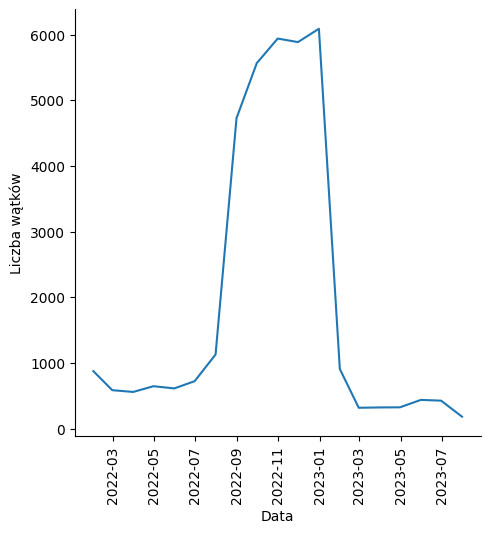

In [ ]:
g = sns.relplot(x="Created Time",
            y="counter",
            data=all_cus_go_plots_count,
            kind="line")

# g.set_title("Liczba wiadomości w ciągu miesiąca")
g.set(xlabel="Data",
      ylabel="Liczba wątków")
plt.xticks(rotation=90)
plt.show()

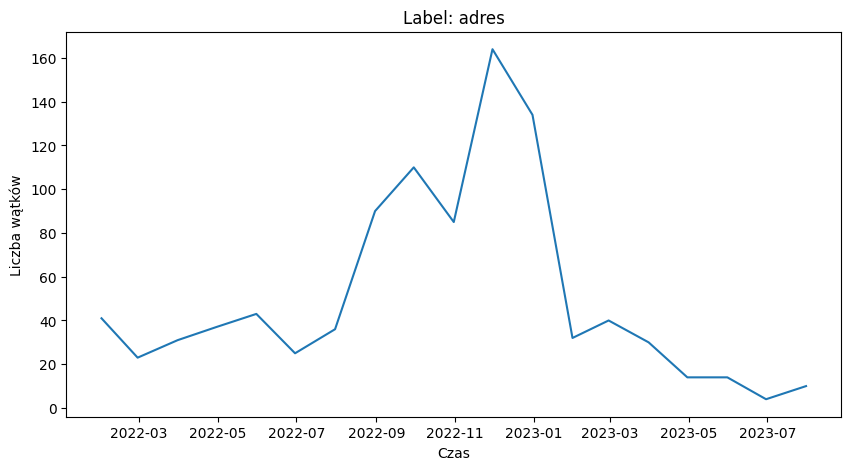

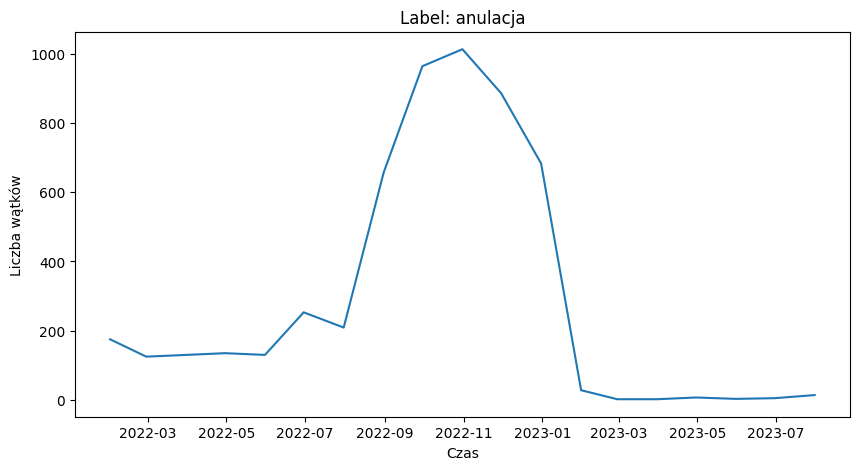

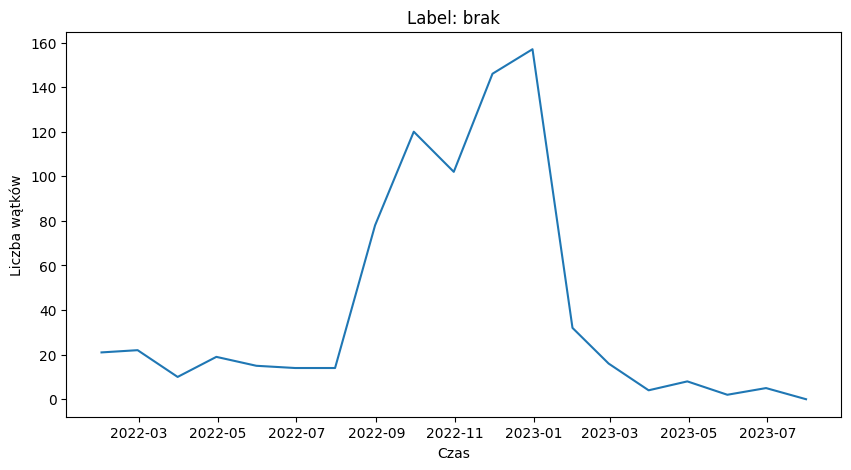

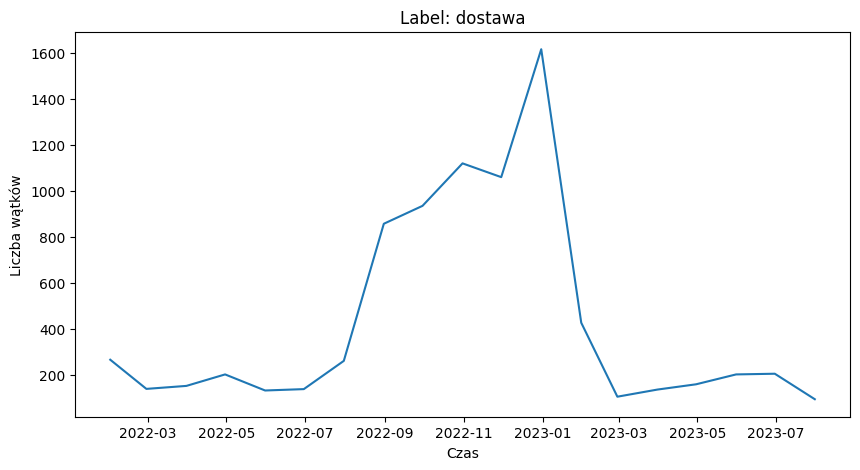

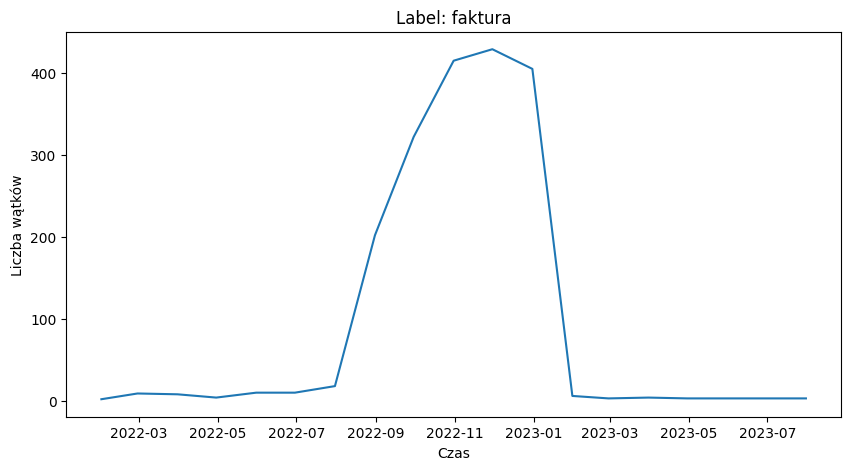

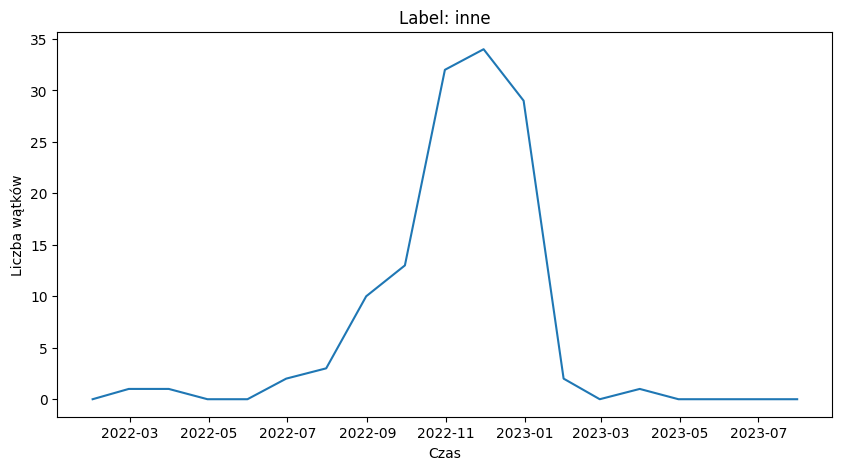

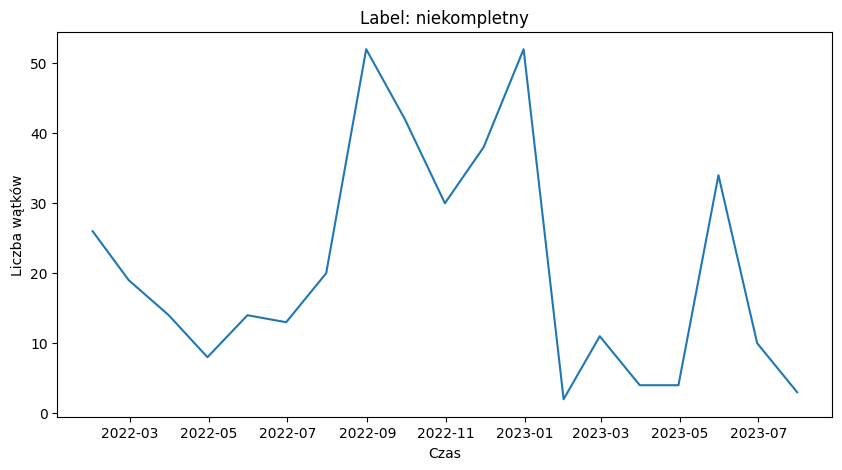

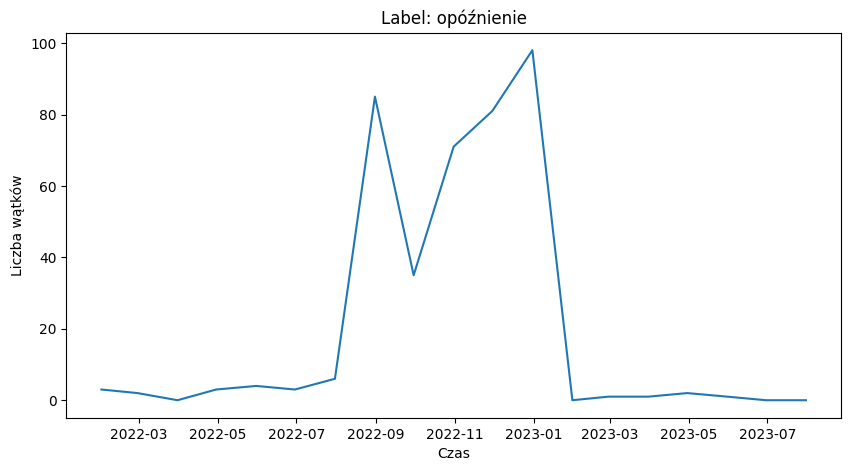

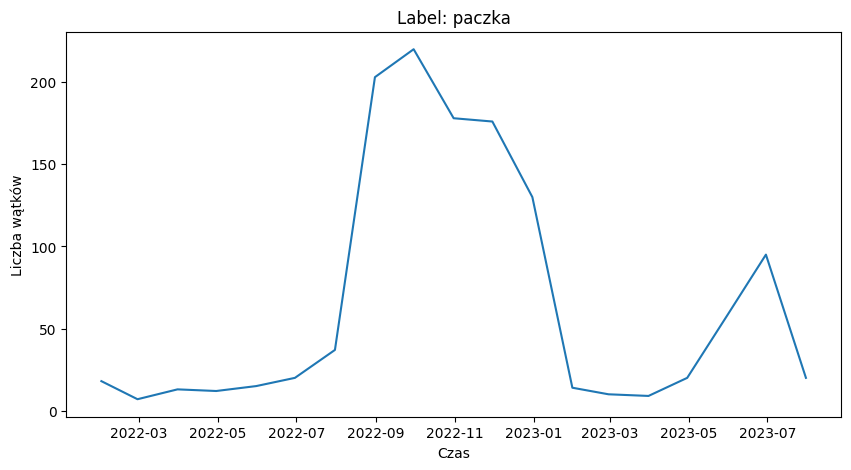

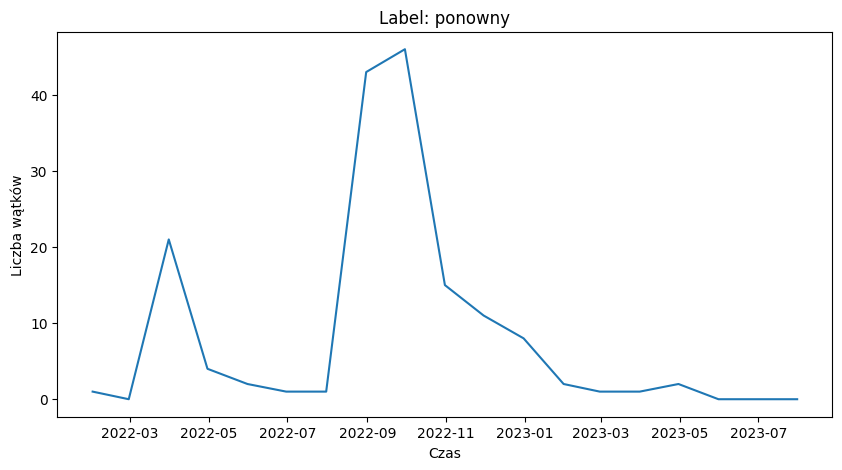

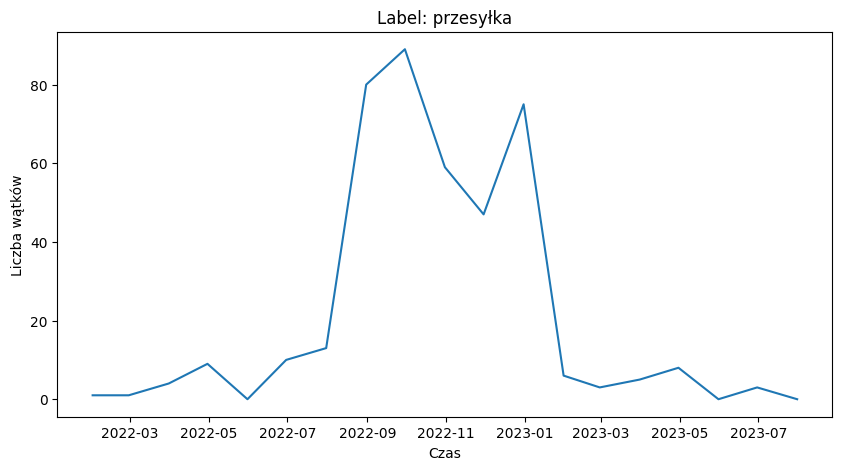

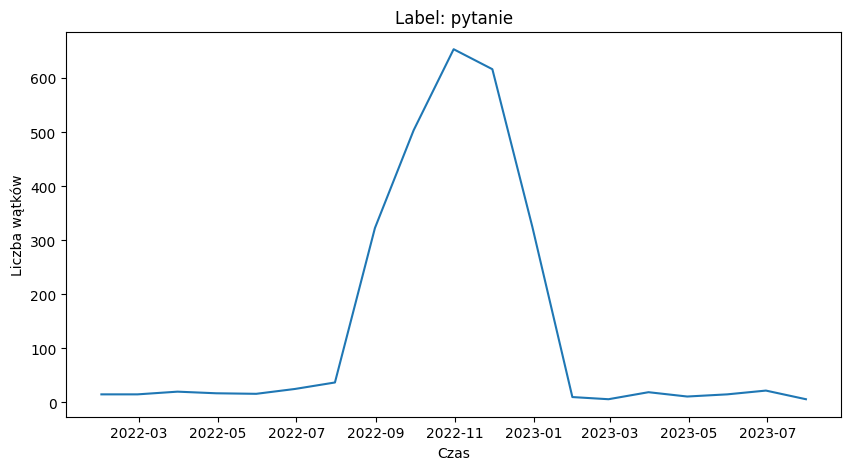

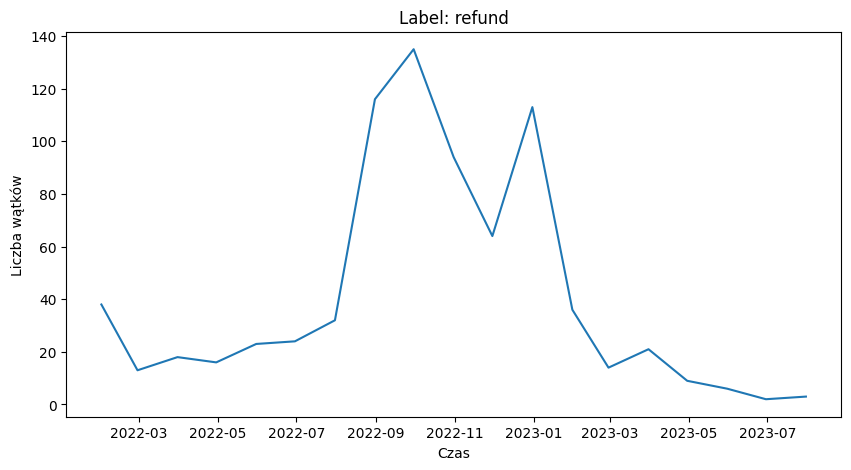

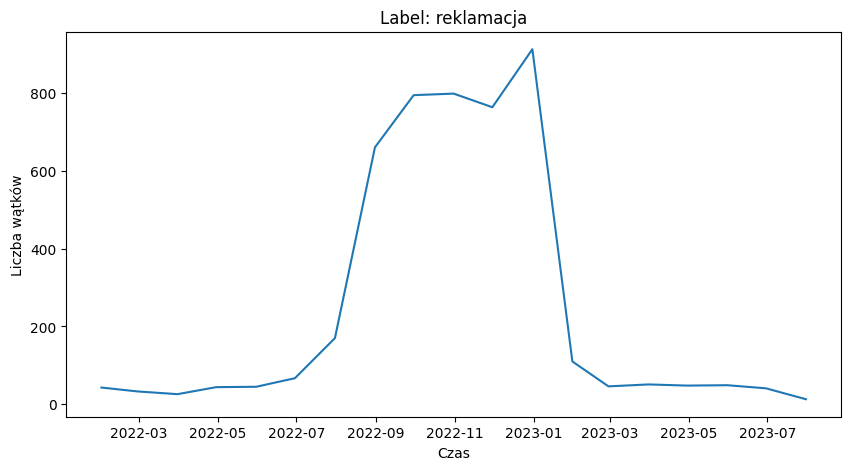

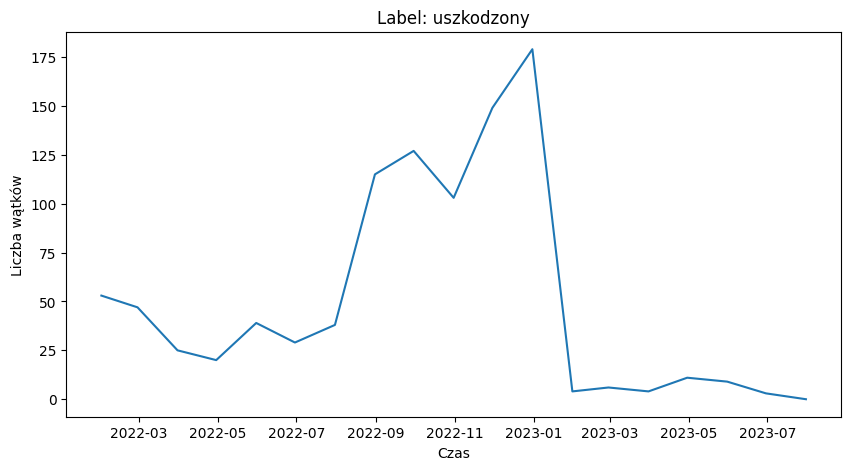

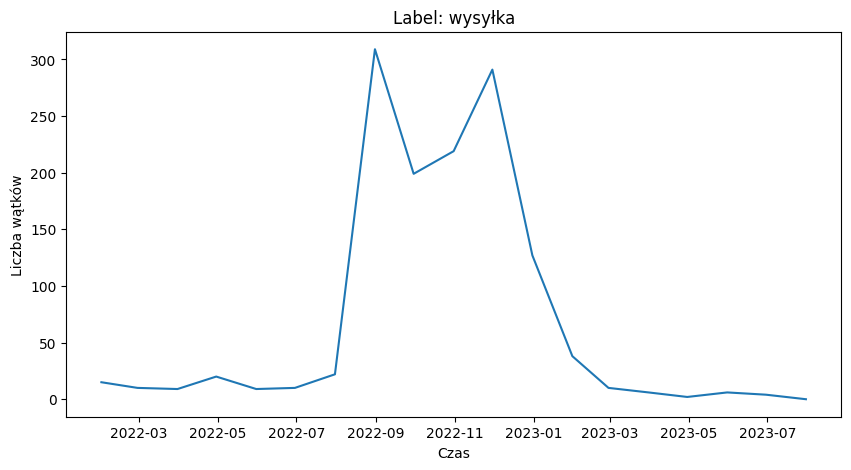

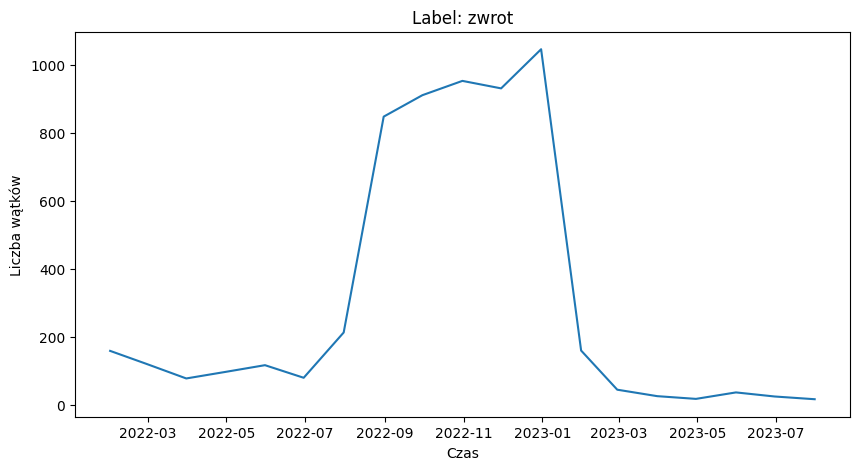

In [ ]:
for column_name in pivot_count_df.columns:
    # Create a new figure for each column
    plt.figure(figsize=(10, 5))
    
    # Plot the data for the current column
    sns.lineplot(x="Created Time",
                 y=column_name,
                 data=pivot_count_df)

    plt.xlabel("Czas")
    plt.ylabel("Liczba wątków")
    plt.title(f"Label: {column_name}")

    # Show the current figure
    plt.show()

In [ ]:
all_cus_go_plots.reset_index(inplace=True)
all_cus_go_plots['Created Time'] = pd.to_datetime(all_cus_go_plots['Created Time'])

pivot_df = all_cus_go_plots.pivot_table(index='Created Time', columns='final_label', values=['Agent interactions', 'Customer interactions'], aggfunc='mean')

pivot_df.columns = [f'{col[1]}_{col[0]}' for col in pivot_df.columns]

pivot_df.reset_index(inplace=True)

pivot_df.set_index('Created Time', inplace=True)
pivot_df = pivot_df.resample('M').mean()
pivot_df.head()

,adres_Agent interactions,anulacja_Agent interactions,brak_Agent interactions,dostawa_Agent interactions,faktura_Agent interactions,inne_Agent interactions,niekompletny_Agent interactions,opóźnienie_Agent interactions,paczka_Agent interactions,ponowny_Agent interactions,...,opóźnienie_Customer interactions,paczka_Customer interactions,ponowny_Customer interactions,przesyłka_Customer interactions,pytanie_Customer interactions,refund_Customer interactions,reklamacja_Customer interactions,uszkodzony_Customer interactions,wysyłka_Customer interactions,zwrot_Customer interactions
Created Time,,,,,,,,,,,,,,,,,,,,,
2022-01-31,1.195122,1.502857,1.952381,2.094340,1.500000,NaN,2.769231,1.333333,1.722222,2.000000,...,1.666667,1.611111,2.0,1.000000,1.933333,1.552632,2.285714,1.943396,1.266667,1.636076
2022-02-28,1.782609,1.288000,2.227273,2.032847,1.333333,1.0,2.684211,3.500000,1.285714,NaN,...,2.500000,1.285714,NaN,1.000000,1.866667,1.230769,2.696970,1.413043,1.500000,2.033613
2022-03-31,1.290323,1.360465,1.700000,1.933775,1.875000,7.0,3.285714,NaN,1.538462,1.047619,...,NaN,1.384615,1.0,1.000000,1.550000,1.444444,2.615385,1.880000,2.777778,1.628205
2022-04-30,1.432432,1.338346,2.368421,1.942500,5.750000,NaN,4.000000,3.666667,2.083333,1.000000,...,3.000000,1.833333,1.0,0.666667,1.176471,0.937500,3.500000,1.950000,1.300000,1.680412
2022-05-31,1.697674,1.605469,2.600000,2.500000,2.900000,NaN,3.357143,4.250000,2.133333,1.000000,...,4.250000,2.066667,1.0,NaN,1.187500,1.086957,2.977778,2.157895,1.888889,1.965812


In [ ]:
# all_cus_go_plots.reset_index(inplace=True)
# all_cus_go_plots_date = pd.DataFrame(all_cus_go_plots[['Created Time','Agent interactions','Customer interactions']])
# all_cus_go_plots_date.set_index('Created Time', inplace=True)
# all_cus_go_plots_date = all_cus_go_plots_date.resample('M').mean()
# all_cus_go_plots_date.head()

In [ ]:
# sns.lineplot(x="Created Time",
#                 y="Agent interactions",
#                 data=all_cus_go_plots_date,
#                 )
# sns.lineplot(x="Created Time",
#                 y="Customer interactions",
#                 data=all_cus_go_plots_date,
#                 )

# plt.xticks(rotation=90)
# plt.xlabel("Czas")
# plt.ylabel("Średnia liczba interakcji w wątku")

# plt.show()

In [ ]:
labels = ['zapytanie', 'niekompletne', 'reklamacja', 'zwrot', 
       'uszkodzony', 'brak', 'faktura', 'adres', 'wysyłka', 'refund',
       'paczka', 'dostawa', 'inne', 'przesyłka', 'opóźnienie', 'anulacja',
       'ponowna']

# Create subplots for each label
fig, axes = plt.subplots(nrows=len(labels), figsize=(10, 5 * len(labels)))

for i, label in enumerate(labels):
    ax = axes[i]

    # Filter the columns related to the current label
    label_cols = [col for col in pivot_df.columns if col.startswith(label)]

    # Plot the data for "Agent interactions"
    sns.lineplot(x="Created Time",
                 y=label_cols[0],
                 data=pivot_df,
                 ax=ax,
                 label=f"{label} Agent interactions")

    # Plot the data for "Customer interactions"
    sns.lineplot(x="Created Time",
                 y=label_cols[1],
                 data=pivot_df,
                 ax=ax,
                 label=f"{label} Customer interactions")

    ax.set_xlabel("Czas")
    ax.set_ylabel("Średnia liczba interakcji w wątku")
    # ax.set_xticklabels(pivot_df["Created Time"], rotation=90)  # Optional, adjust the x-axis labels

    ax.set_title(f"Label: {label}")

plt.tight_layout()
plt.show()

IndexError: list index out of range

Error in callback <function flush_figures at 0x0000026614336CA0> (for post_execute):


KeyboardInterrupt: 

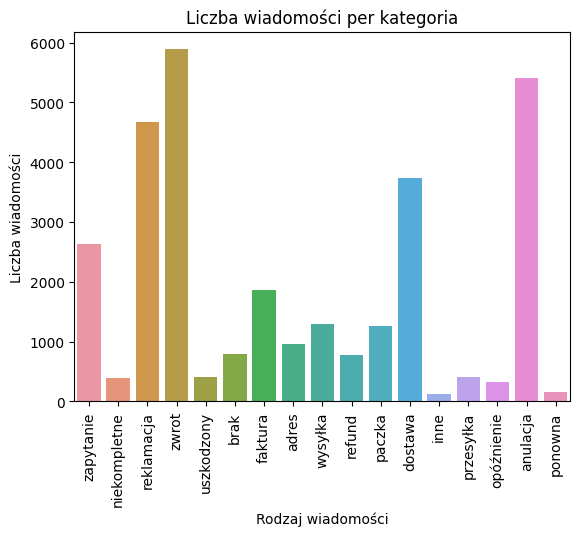

In [ ]:
g = sns.countplot(x=all_cus_go['final_label'])

g.set_title("Liczba wiadomości per kategoria")
g.set(xlabel="Rodzaj wiadomości",
      ylabel="Liczba wiadomości")
plt.xticks(rotation=90)
plt.show()

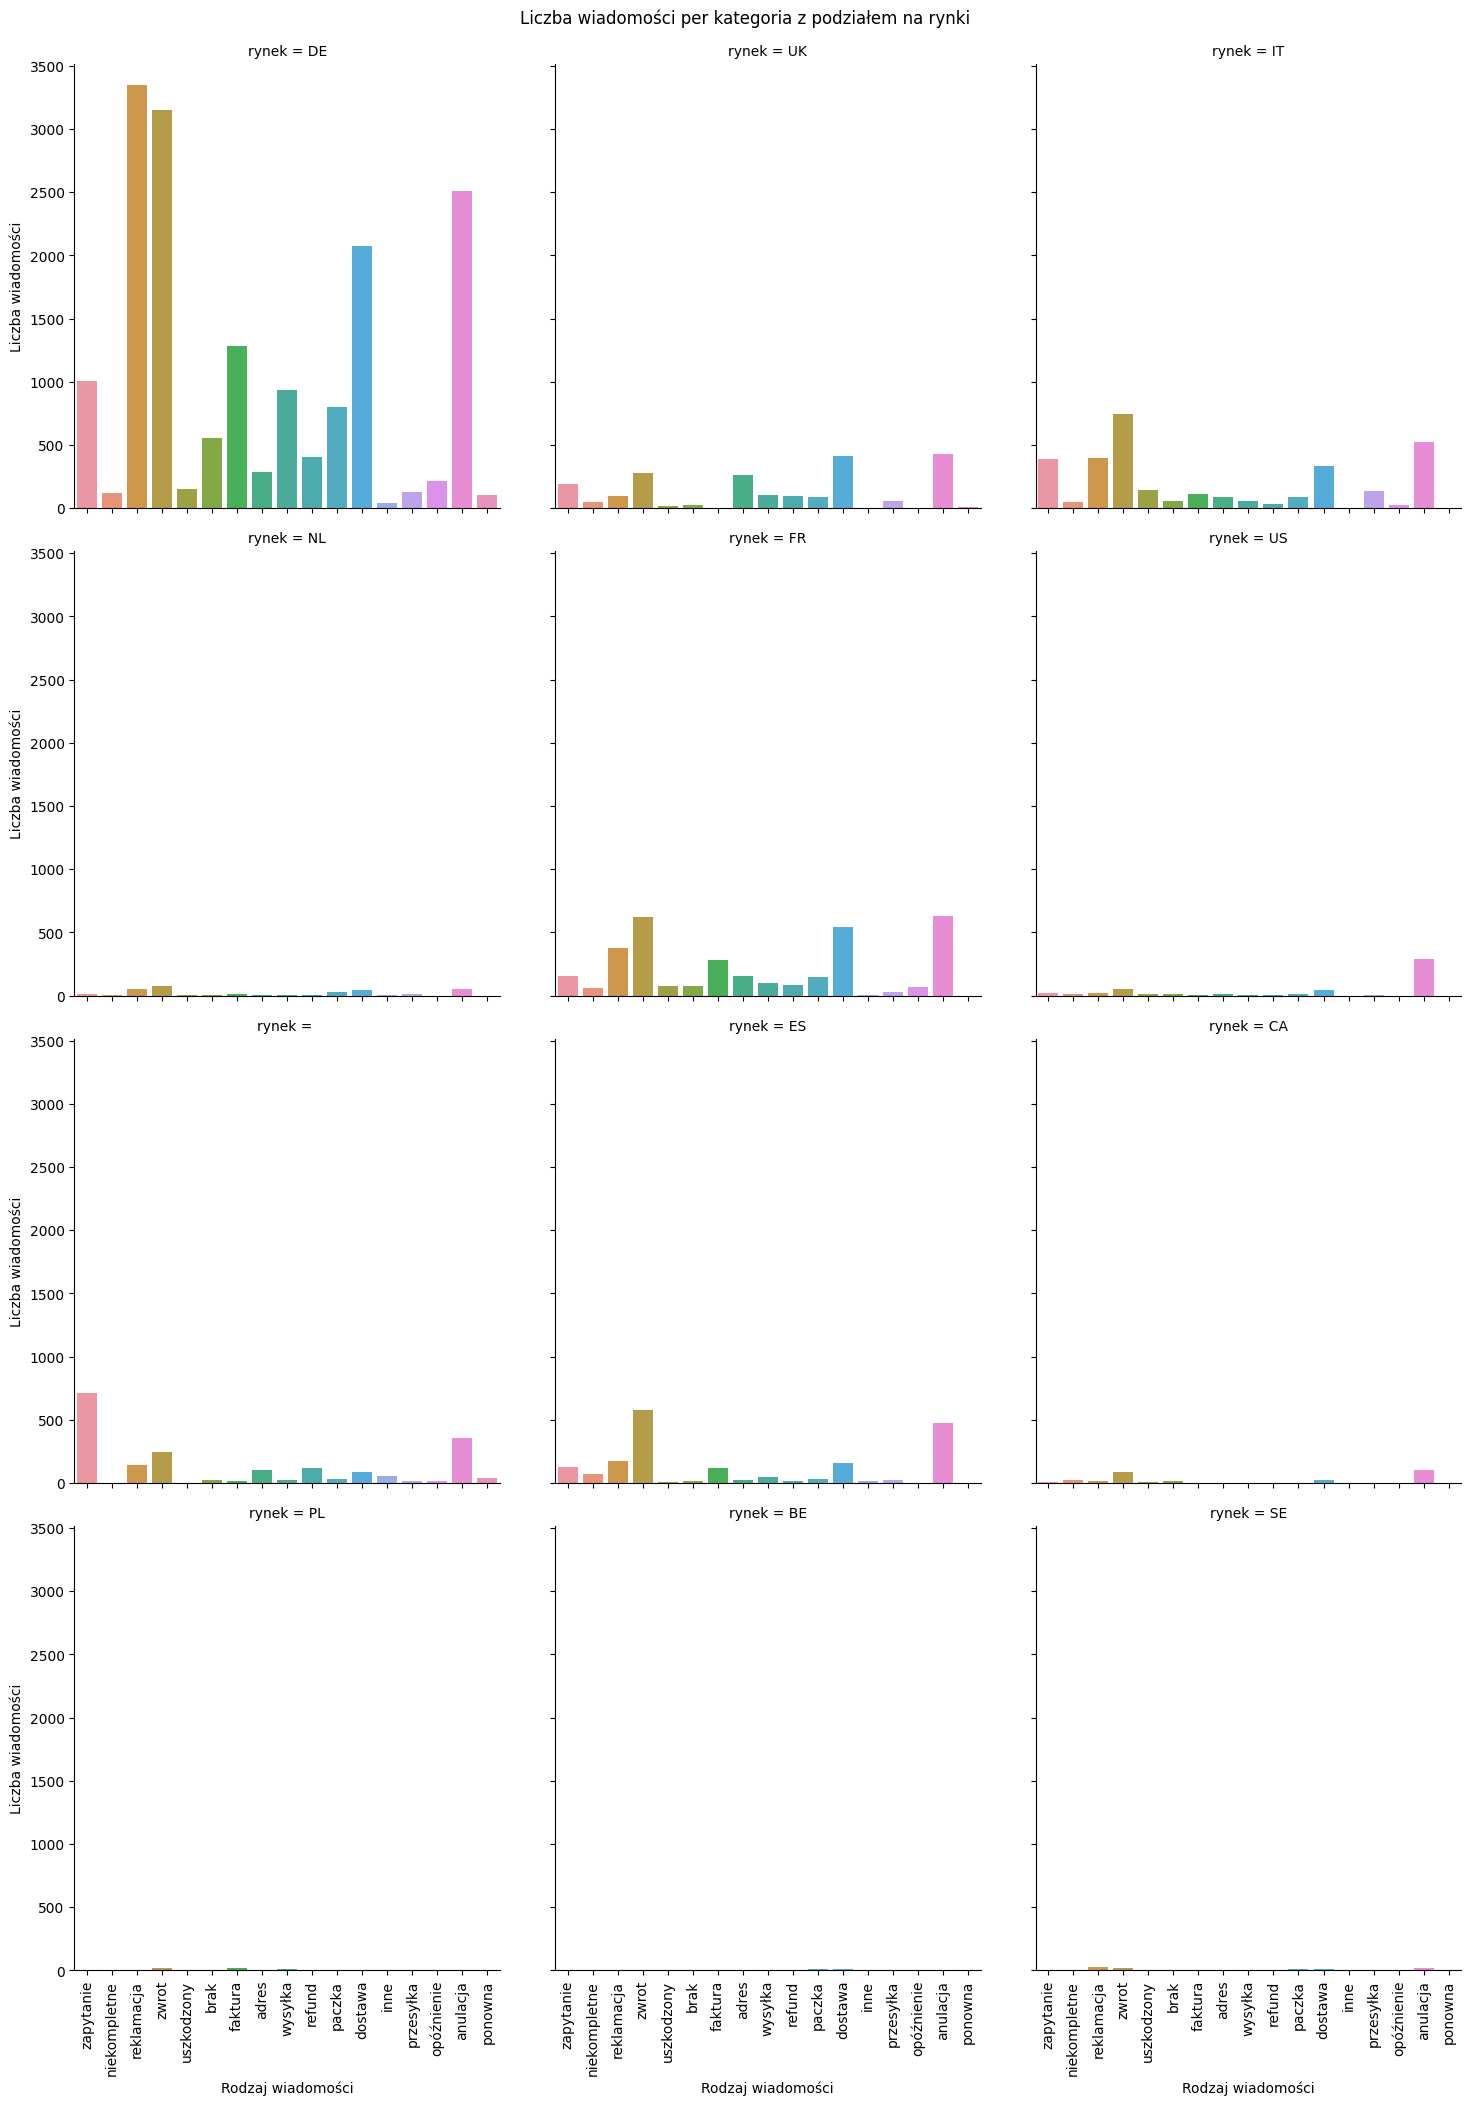

In [ ]:
g = sns.catplot(x='final_label',
            data=all_cus_go_plots,
            kind='count',
            col="rynek",
            col_wrap=3)

g.fig.suptitle("Liczba wiadomości per kategoria z podziałem na rynki", y=1.01)
g.set_axis_labels("Rodzaj wiadomości", "Liczba wiadomości")


for ax in g.axes.flat:
    plt.sca(ax)
    plt.xticks(rotation=90)

# plt.show()

plt.show()

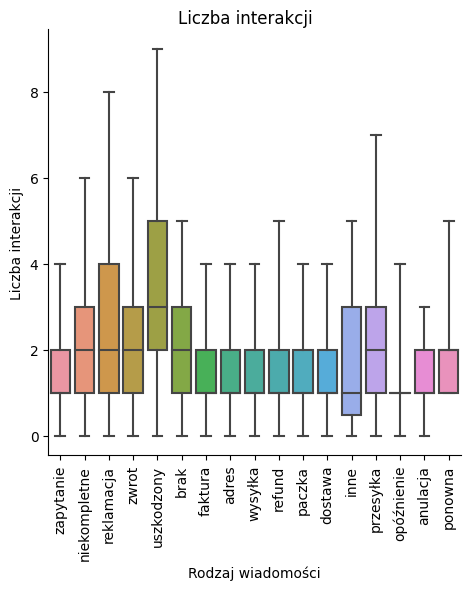

In [ ]:
g = sns.catplot(y='Agent interactions',
                x='final_label',
                data=all_cus_go_plots,
                kind='box',
                sym="",
                whis=[0,95])

g.fig.suptitle("Liczba interakcji", y=1.01)
g.set_axis_labels("Rodzaj wiadomości", "Liczba interakcji")

plt.xticks(rotation=90)
plt.show()

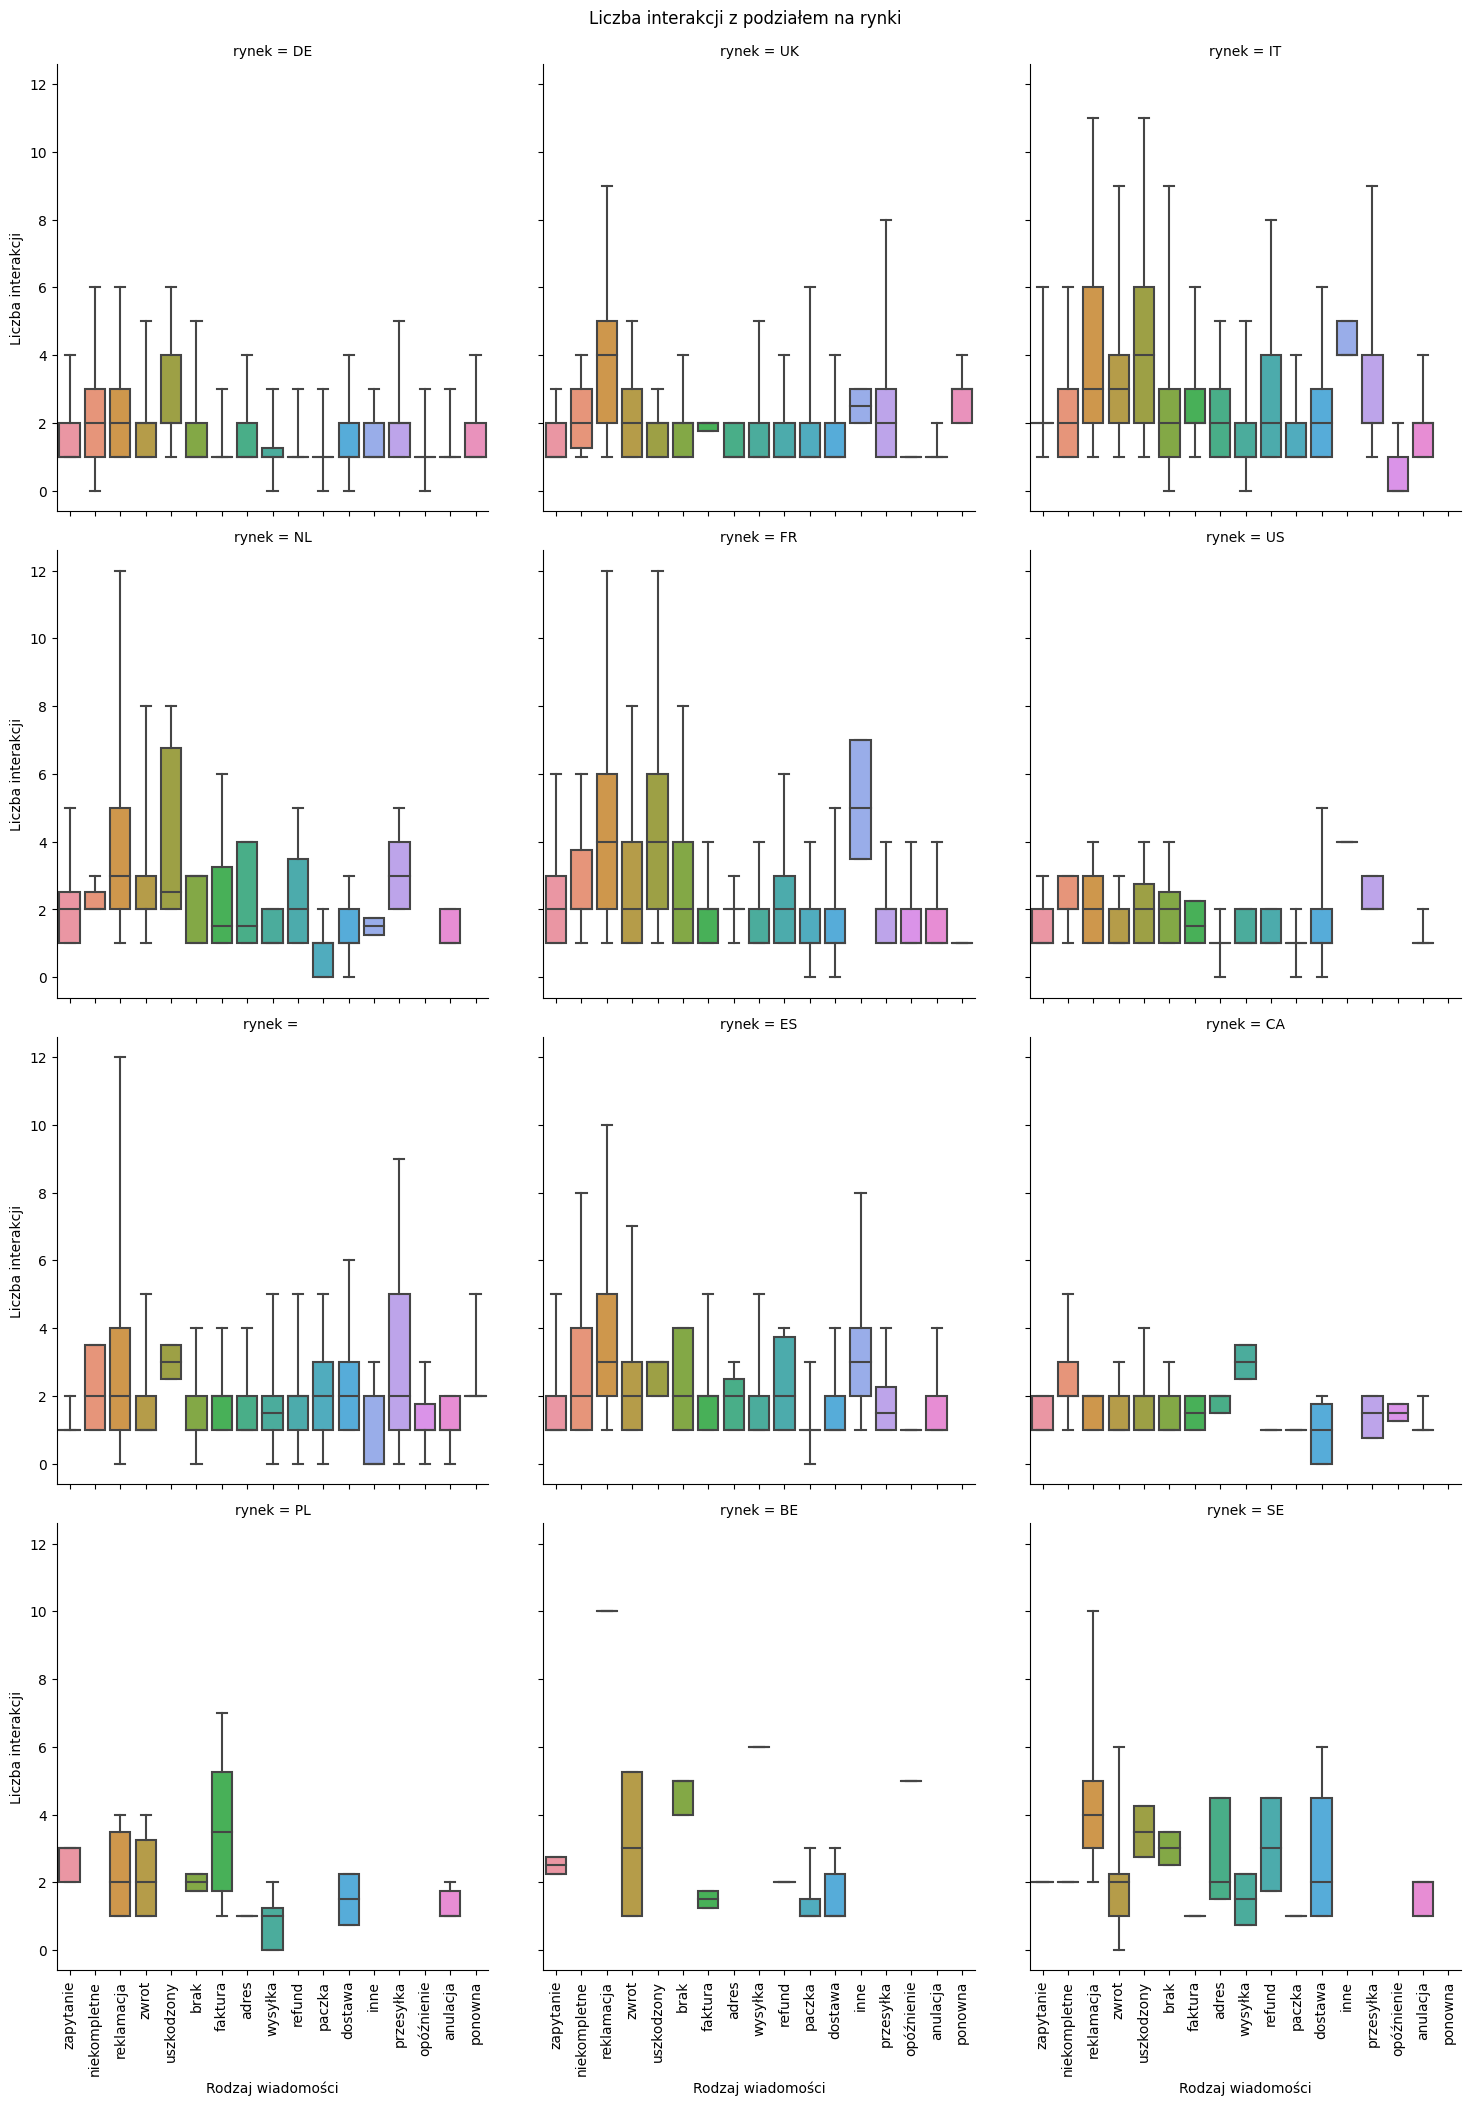

In [ ]:
g = sns.catplot(y='Agent interactions',
                x='final_label',
                data=all_cus_go_plots,
                kind='box',
                sym="",
                whis=[5,95],
                col='rynek',
                col_wrap=3)

g.fig.suptitle("Liczba interakcji z podziałem na rynki", y=1.01)
g.set_axis_labels("Rodzaj wiadomości", "Liczba interakcji")

for ax in g.axes.flat:
    plt.sca(ax)
    plt.xticks(rotation=90)

plt.show()

dostawa         8193
zwrot           5878
anulacja        5421
reklamacja      4713
pytanie         2657
faktura         1859
wysyłka         1306
paczka          1255
adres            963
uszkodzony       961
brak             785
refund           776
przesyłka        413
niekompletny     396
opóźnienie       396
ponowny          159
inne             128
Name: final_label, dtype: int64

In [ ]:
df_to_model = pd.DataFrame()
for i in all_cus_go['final_label'].unique():
    subset = all_cus_go[all_cus_go['final_label'] == i].head(1000).reset_index(drop=True)
    df_to_model = pd.concat([df_to_model, subset], axis=0)

In [ ]:
df_to_model['final_label'].value_counts()

zapytanie       1000
faktura         1000
anulacja        1000
dostawa         1000
paczka          1000
wysyłka         1000
zwrot           1000
reklamacja      1000
adres            957
brak             796
refund           773
uszkodzony       416
przesyłka        411
niekompletne     396
opóźnienie       332
ponowna          159
inne             127
Name: final_label, dtype: int64

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
X = df_to_model['Description']
y = df_to_model['final_label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
tfidf = TfidfVectorizer()
tfidf.fit(X_train)

TfidfVectorizer()

In [ ]:
X_train_tf = tfidf.transform(X_train)
X_test_tf = tfidf.transform(X_test)

In [ ]:
X_train_tf.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
tfidf.get_feature_names_out()

array(['00', '000', '0000', ..., 'żądany', 'żądanych', 'żę'], dtype=object)

In [ ]:
pd.DataFrame(X_train_tf.todense(),
             columns=tfidf.get_feature_names_out())

,00,000,0000,0000000,000000992432,0000028368,0000047237,0000142805,0000357766,0000373427,...,żółtej,żółto,żółty,żąda,żądają,żądam,żądaniem,żądany,żądanych,żę
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:


lr = LogisticRegression()
lr.fit(X_train_tf, y_train)

y_pred = lr.predict(X_test_tf)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       adres       0.75      0.92      0.83       185
    anulacja       0.96      0.91      0.93       171
        brak       0.81      0.73      0.77       161
     dostawa       0.69      0.27      0.39       204
     faktura       0.98      0.95      0.96       214
        inne       0.79      0.58      0.67        19
niekompletne       0.88      0.80      0.84        80
  opóźnienie       0.77      0.56      0.65        59
      paczka       0.90      0.76      0.83       199
     ponowna       0.83      0.68      0.75        44
   przesyłka       0.82      0.78      0.80        78
      refund       0.82      0.82      0.82       148
  reklamacja       0.67      0.84      0.75       211
  uszkodzony       0.81      0.69      0.75        83
     wysyłka       0.54      0.88      0.67       205
   zapytanie       0.88      0.93      0.90       207
       zwrot       0.74      0.74      0.74       206

    accuracy              

In [ ]:


rfc = RandomForestClassifier()
rfc.fit(X_train_tf, y_train)

y_pred = rfc.predict(X_test_tf)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       adres       0.79      0.91      0.85       185
    anulacja       0.92      0.91      0.91       171
        brak       0.82      0.71      0.76       161
     dostawa       0.67      0.26      0.37       204
     faktura       0.94      0.96      0.95       214
        inne       0.79      0.58      0.67        19
niekompletne       0.81      0.82      0.82        80
  opóźnienie       0.79      0.53      0.63        59
      paczka       0.89      0.78      0.83       199
     ponowna       0.91      0.68      0.78        44
   przesyłka       0.82      0.71      0.76        78
      refund       0.88      0.82      0.85       148
  reklamacja       0.66      0.83      0.73       211
  uszkodzony       0.82      0.77      0.80        83
     wysyłka       0.57      0.88      0.69       205
   zapytanie       0.85      0.93      0.89       207
       zwrot       0.72      0.77      0.75       206

    accuracy              

In [ ]:


mnb = MultinomialNB()
mnb.fit(X_train_tf, y_train)

y_pred = mnb.predict(X_test_tf)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       adres       0.72      0.89      0.79       185
    anulacja       0.81      0.92      0.86       171
        brak       0.69      0.46      0.55       161
     dostawa       0.79      0.11      0.19       204
     faktura       0.96      0.93      0.94       214
        inne       0.77      0.53      0.62        19
niekompletne       1.00      0.23      0.37        80
  opóźnienie       0.66      0.39      0.49        59
      paczka       0.84      0.57      0.68       199
     ponowna       0.00      0.00      0.00        44
   przesyłka       0.97      0.42      0.59        78
      refund       0.82      0.72      0.77       148
  reklamacja       0.48      0.85      0.62       211
  uszkodzony       1.00      0.18      0.31        83
     wysyłka       0.42      0.84      0.56       205
   zapytanie       0.90      0.88      0.89       207
       zwrot       0.48      0.79      0.60       206

    accuracy              

spaCy model

In [ ]:
nlp = spacy.blank("pl")

In [ ]:
df = pd.DataFrame(df_to_model[['Description', 'final_label']])
df.reset_index(inplace=True)

In [ ]:
REGX_URL = r"(https?://|www\.)[^\s/$.?#].[^\s]*"

def preprocessing(text):
  text = text.lower()
  text = text.replace("&quot;", '"')

  text = re.sub(REGX_URL, ' ', text)

  tokens = [token.text for token in nlp(text)]

  tokens = [t for t in tokens if 
              t not in STOP_WORDS and 
              t not in string.punctuation]

  tokens = [t for t in tokens if not t.isdigit()]

  return " ".join(tokens)

In [ ]:
df['Description_cleaned'] = df['Description'].apply(preprocessing)

In [ ]:
y =pd.get_dummies((df['final_label']), prefix='label')
label = list(y.columns)
y = y.to_dict('index')

In [ ]:
dataset = list(zip(df['Description_cleaned'], [{'cats':cats} for cats in y.values()]))
print(dataset[0])

('klient ma pytanie produktu b07r42w8j9 jakie połączenie ma dachówka wentylacyjna link zapytania    pozdrawiam beata', {'cats': {'label_adres': 0, 'label_anulacja': 0, 'label_brak': 0, 'label_dostawa': 0, 'label_faktura': 0, 'label_inne': 0, 'label_niekompletne': 0, 'label_opóźnienie': 0, 'label_paczka': 0, 'label_ponowna': 0, 'label_przesyłka': 0, 'label_refund': 0, 'label_reklamacja': 0, 'label_uszkodzony': 0, 'label_wysyłka': 0, 'label_zapytanie': 1, 'label_zwrot': 0}})


In [ ]:
train_data, test_data = train_test_split(dataset,
                                        test_size=0.25,
                                        random_state=42)
dev_data, test_data = train_test_split(test_data, 
                                       test_size=0.4,
                                       random_state=42)

print(f"Total: {len(dataset)} - Train:  {len(train_data)} - Dev: {len(dev_data)} - Test: {len(test_data)}")

Total: 12367 - Train:  9275 - Dev: 1855 - Test: 1237


In [ ]:
def convert(data, outfile):
    db = spacy.tokens.DocBin()

    for text, labels in data:
        doc = spacy.tokens.Doc(nlp.vocab, words=text.split())
        doc.cats.update(labels['cats'])
        db.add(doc)

    db.to_disk(outfile)

convert(train_data, "./train.spacy")
convert(dev_data, "./dev.spacy")
convert(test_data, "./test.spacy")

In [ ]:
textcat = nlp.add_pipe("textcat_multilabel")
for i in label:
    textcat.add_label(i)

In [ ]:
# ! python -m spacy init fill-config base_config.cfg config.cfg

In [ ]:
# ! python -m spacy train config.cfg --paths.train ./train.spacy  --paths.dev ./dev.spacy --output model --verbose

In [ ]:
# output_dir = 'C:\\Users\\48575\\email_classification\\spaCy_model'
# nlp.to_disk(output_dir)

In [ ]:
saved_model_dir = 'C:\\Users\\48575\\email_classification\\spaCy_model'
nlp = spacy.load(saved_model_dir)

In [ ]:
! python -m spacy evaluate ./model/model-best/ ./test.spacy

ℹ Using CPU

================================== Results ==================================

TOK                   -     
TEXTCAT (macro AUC)   94.27 
SPEED                 184911


=========================== Textcat F (per label) ===========================

                          P       R       F
label_adres          100.00   93.18   96.47
label_anulacja        98.70   95.00   96.82
label_brak            92.94   84.04   88.27
label_dostawa         94.74   31.58   47.37
label_faktura        100.00   97.25   98.60
label_inne           100.00   35.71   52.63
label_niekompletne    92.59   71.43   80.65
label_opóźnienie     100.00   18.18   30.77
label_paczka          98.80   85.42   91.62
label_ponowna         94.12   66.67   78.05
label_przesyłka       94.12   80.00   86.49
label_refund          94.29   89.19   91.67
label_reklamacja      89.04   60.75   72.22
label_uszkodzony      94.74   83.72   88.89
label_wysyłka         92.86   15.66   26.80
label_zapytanie       98.84   83.33 

In [ ]:
def predict_spaCy (text):
    preprocessed_text = preprocessing(text)
    doc = nlp(preprocessed_text)
    label = max(doc.cats, key=doc.cats.get)
    return label

Optimization of Logistic Regression, Random Forest Classifier, and Naive Bayes

In [ ]:
X = df['Description_cleaned']
y = df['final_label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
tfidf = TfidfVectorizer()
tfidf.fit(X_train)

TfidfVectorizer()

In [ ]:
X_train_tf = tfidf.transform(X_train)
X_test_tf = tfidf.transform(X_test)

In [ ]:
X_train_tf.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:


lr = LogisticRegression()
lr.fit(X_train_tf, y_train)

y_pred = lr.predict(X_test_tf)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       adres       0.73      0.94      0.82       185
    anulacja       0.96      0.91      0.93       171
        brak       0.80      0.73      0.76       161
     dostawa       0.74      0.26      0.39       204
     faktura       0.98      0.94      0.96       214
        inne       0.79      0.58      0.67        19
niekompletne       0.89      0.79      0.83        80
  opóźnienie       0.79      0.56      0.65        59
      paczka       0.92      0.78      0.85       199
     ponowna       0.83      0.66      0.73        44
   przesyłka       0.83      0.76      0.79        78
      refund       0.87      0.82      0.85       148
  reklamacja       0.65      0.84      0.73       211
  uszkodzony       0.81      0.69      0.75        83
     wysyłka       0.55      0.90      0.68       205
   zapytanie       0.88      0.92      0.90       207
       zwrot       0.75      0.75      0.75       206

    accuracy              

In [ ]:
param_grid = {
    'penalty': ['l1','l2','None'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'tol' : [0.001,0.01],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'max_iter': [100, 200],
    'multi_class': ['auto', 'multinomial'],
}

In [ ]:
# searcher=RandomizedSearchCV(lr, param_grid)
# searcher.fit(X_train_tf, y_train)

In [ ]:
# joblib.dump(searcher, "LogisticRegression_randomizedSearchCV")

In [ ]:
searcher = joblib.load("LogisticRegression_randomizedSearchCV")

In [ ]:
print(searcher.best_score_)
print(searcher.best_params_)

0.7918849153934211
{'solver': 'saga', 'penalty': 'l2', 'multi_class': 'ovr', 'fit_intercept': True, 'C': 10}


In [ ]:
lr = LogisticRegression(tol=0.01, solver='newton-cg', penalty='l2', multi_class='multinomial', 
                        max_iter=200, fit_intercept=True, C=10
                        )
lr.fit(X_train_tf, y_train)

y_pred = lr.predict(X_test_tf)


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       adres       0.83      0.91      0.87       185
    anulacja       0.95      0.91      0.93       171
        brak       0.79      0.81      0.80       161
     dostawa       0.71      0.34      0.46       204
     faktura       0.96      0.96      0.96       214
        inne       0.73      0.58      0.65        19
niekompletne       0.90      0.80      0.85        80
  opóźnienie       0.94      0.56      0.70        59
      paczka       0.91      0.83      0.87       199
     ponowna       0.81      0.80      0.80        44
   przesyłka       0.80      0.77      0.78        78
      refund       0.90      0.84      0.87       148
  reklamacja       0.71      0.81      0.75       211
  uszkodzony       0.81      0.76      0.78        83
     wysyłka       0.57      0.92      0.70       205
   zapytanie       0.92      0.92      0.92       207
       zwrot       0.76      0.79      0.77       206

    accuracy              

In [ ]:

rfc = RandomForestClassifier()
rfc.fit(X_train_tf, y_train)

y_pred = rfc.predict(X_test_tf)



print(classification_report(y_test, y_pred))

: 

In [ ]:
param_grid = {
    'n_estimators': [50, 125, 200],  # Range of values for n_estimators
    'max_depth': [None, 5, 13, 20],  # Including None for no max depth
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

In [ ]:
# searcher=RandomizedSearchCV(rfc, param_grid)
# searcher.fit(X_train_tf, y_train)

In [ ]:
# joblib.dump(searcher, "RandomForestClassifier_randomizedSearchCV")

In [ ]:
searcher = joblib.load("LogisticRegression_randomizedSearchCV")

In [ ]:
print(searcher.best_score_)
print(searcher.best_params_)

0.7918849153934211
{'solver': 'saga', 'penalty': 'l2', 'multi_class': 'ovr', 'fit_intercept': True, 'C': 10}


In [ ]:
# rfc = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=None, max_depth=None, criterion='gini')
# rfc.fit(X_train_tf, y_train)

# y_pred = rfc.predict(X_test_tf)

# from sklearn.metrics import classification_report

# print(classification_report(y_test, y_pred))